# Finding the epidemic threshold

SIR epidemics on ER networks are known to have an *epidemic threshold*, a value of transmissibility below which large-scale outbreak doesn't occur, and above which one almost always forms.

In [1]:
import os
from datetime import datetime, timedelta
from math import factorial
from numpy import linspace
from epyc import LabNotebook, Experiment
from cloudepyc import CloudLab
from epydemic import ERNetwork, SIR, StochasticDynamics
from epydemic.gf import gf_er

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt

In [2]:
nb = LabNotebook()
lab = CloudLab(os.environ["EPYDEMIC_API_GATEWAY_ENDPOINT"], notebook=nb)

In [3]:
# network parameters
lab[ERNetwork.N] = int(1e4)
lab[ERNetwork.KMEAN] = 10

# disease parameters
lab[SIR.P_INFECTED] = 0.001
lab[SIR.P_REMOVE] = 0.002

The value of this critical threshold $\phi_c$ can be found analytically and is related to the *Molloy-Reed criterion* for percolation on a network:

$$
\phi_c = \frac{\langle k \rangle}{\langle k^2 \rangle - \langle k \rangle}
$$

where $\langle k \rangle$ and $\langle k^2 \rangle$ are respectively the mean and variance of the degree distribution and $p_k$ is the probability of a node having degree $k$. This expression can be computed in terms of generating functions. If $G_0(x)$ is the generating function for the degree distribution of the network, then

$$
G_1(x) = \frac{G'_0(x)}{G'_0(1)} = \frac{1}{\langle k \rangle} G'_0(x)
$$

is the generating function of excess degrees (where $G'_0(x) = \frac{d}{dx}G_0(x)$). The critical threshold is then given by

$$
\phi_c = \frac{1}{G'_1(1)}
$$

The critical threshold for an epidemic outbreak occurs when the $\mathcal{R}$ value of the disease exceeds $\phi_c$. Since

$$
\mathcal{R} = \frac{\mathit{p_{infect}}}{\mathit{p_{remove}}}
$$

the critical infection threshold is 


$$
p_c = \mathit{p_{remove}} \, \phi_c = \frac{\mathit{p_{remove}}}{G'_1(1)}
$$

In [4]:
G0 = gf_er(lab[ERNetwork.N][0], kmean=lab[ERNetwork.KMEAN][0])

# should be simply
#
# G1 = G0.dx() / lab[ERNetwork.KMEAN][0]
#
# but epydemic's generating functions don't yet support multiplication by a constant. so....
from epydemic.gf import ContinuousGF
G0prime = G0.dx()
G1 = ContinuousGF(lambda x: G0prime._f(x) / lab[ERNetwork.KMEAN][0], order=G0prime._order)

p_c = float(lab[SIR.P_REMOVE][0] / G1.dx()(1))

We can then focus on the behaviour of the epidemic around this critical threshold.

In [5]:
# critical region
lab[SIR.P_INFECT] = linspace(0.00001, 10 * p_c, num=50)

# repetiotions
lab["reps"] = range(10)

In [6]:
m = SIR()
e = StochasticDynamics(m, ERNetwork())
lab.runExperiment(e)

In [22]:
lab.updateResults()
nb.numberOfPendingResults()

0

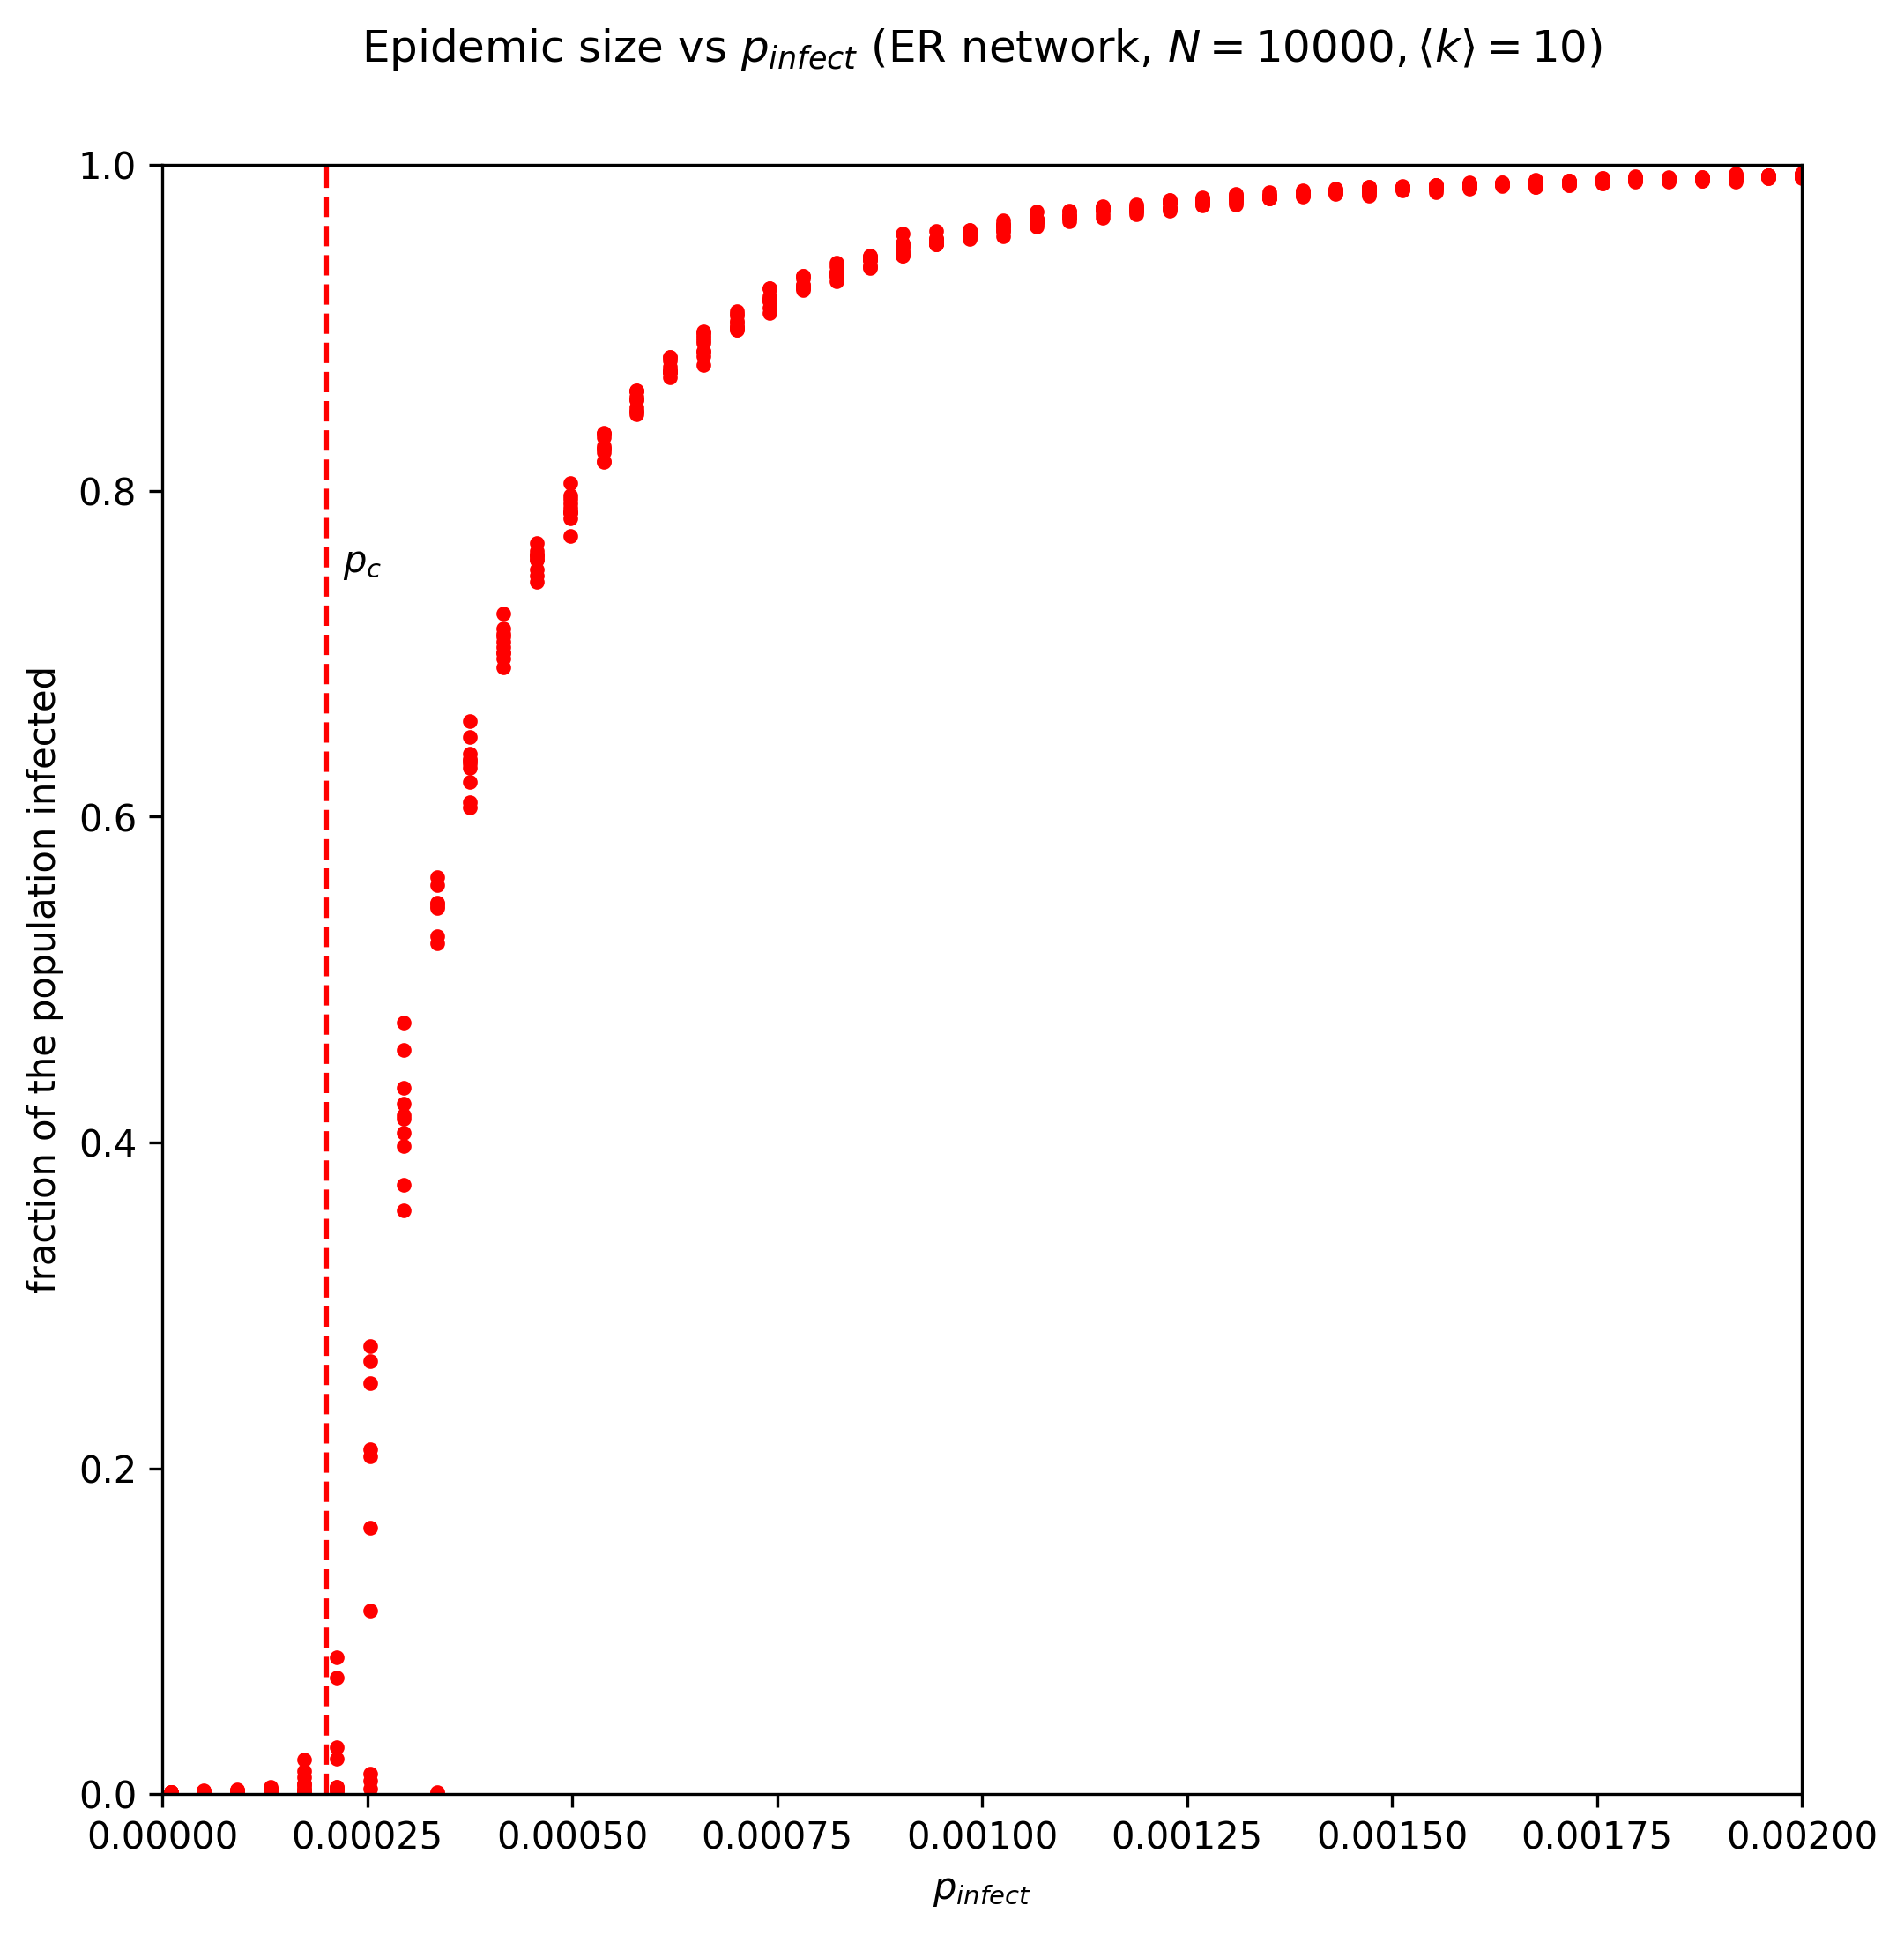

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
networkDescription = 'ER network, $N = {N}, \\langle k \\rangle = {kmean}$'.format(N=lab[ERNetwork.N][0],
                                                                                   kmean=lab[ERNetwork.KMEAN][0])

title = "Epidemic size vs $\mathit{p_{infect}}$" + f" ({networkDescription})"

df = nb.dataframe()

# the data
ax.plot(df[SIR.P_INFECT],
        df[SIR.REMOVED] / lab[ERNetwork.N], 'r.')

# the critical threshold
ax.plot([p_c, p_c], [0.0, 1.0], 'r--')

# labelling
ax.set_xlabel('$p_{\\mathit{infect}}$')
ax.set_ylabel('fraction of the population infected')
ax.annotate(text="$p_c$", xy=(p_c * 1.1, 0.75))
ax.set_xlim([0.0, df[SIR.P_INFECT].max()])
ax.set_ylim([0.0, 1.0])
ax.set_title(title, y=1.05)

plt.show()